<a href="https://colab.research.google.com/github/kutay-oksuzz/Flight-Deals/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification, bir şeyin bir şey mi yoksa başka bir şey mi olduğunu tahmin etme sorunudur (seçenekler birden fazla olabilir).

Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/ 

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


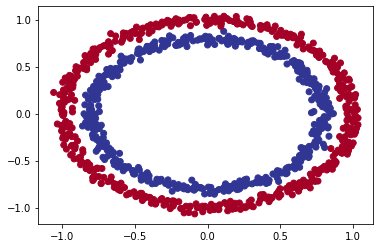

In [6]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: Çalıştığımız veriler genellikle oyuncak veri kümesi olarak adlandırılır, deney yapmak için yeterince küçük ama yine de temelleri uygulamak için yeterince büyük bir veri kümesi.

### 1.1 Check input and putput shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [10]:
import torch
torch.__version__

'1.13.1+cu116'

In [11]:
X.dtype, y.dtype

(dtype('float64'), dtype('int64'))

In [12]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [13]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [14]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42) 

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a mode

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if the is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a traninig and test loop

In [16]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Verilerimizin şekillerini işleyebilen 2 `nn.linear()` katmanı oluşturun
3. Modelin ileri geçişini (veya ileri hesaplamasını) özetleyen bir `forward()` yöntemini tanımlayın
4. Model sınıfımızın bir örneğini oluşturun ve onu hedef "device" gönderin

**Canlandırmak için** - https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=5,2&seed=0.89358&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

In [17]:
# 1. nn.Module alt sınıflarını içeren bir model oluşturun
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Verilerimizin şekillerini işleyebilen 2 nn.linear() katmanı oluşturun
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # 2 özellik alır ve 5 özelliğe yükseltir. layer_1 çıkışı ile layer_2 girişi aynı olmak zorunda
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # önceki katmandan 5 özellik alır ve tek bir özellik çıkarır (y ile aynı şekil)
    
  #3. Modelin ileri geçişini (veya ileri hesaplamasını) özetleyen bir `forward()` yöntemini tanımlayın
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

#4. Model sınıfımızın bir örneğini oluşturun ve onu hedef "device" gönderin
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [19]:
# Yukarıdaki modeli nn.Sequential() kullanarak çoğaltalım.
model_0 = nn.Sequential(
     nn.Linear(in_features=2, out_features=5),
     nn.Linear(in_features=5, out_features=1)   
 ).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.2162, -0.0403],
                      [-0.0614, -0.2750],
                      [-0.6732, -0.0411],
                      [-0.3189, -0.4829],
                      [ 0.2808,  0.1866]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.5726,  0.0859,  0.3665,  0.1897, -0.6212], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.2893, -0.2382,  0.0312, -0.3244,  0.3040]], device='cuda:0')),
             ('1.bias', tensor([0.4438], device='cuda:0'))])

In [21]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")  

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.4397],
        [0.6091],
        [0.0942],
        [0.5372],
        [0.2508],
        [0.3530],
        [0.7060],
        [0.6464],
        [0.0881],
        [0.6222]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Hangi loss function ya da optimizer kullanmalıyız ?

Again.. this is problem specific.

Örneğin, regresyon için MAE veya MSE kullanabilirsiniz (ortalama mutlak hata veya ortalama karesel hata).

Classification için ise binary cross entropy ya da categorical cross entropy(cross entropy) kullanmak isteyebilirsiniz.

Hatırlayalım, the loss function measures how *wrong* your models.

Optimize ediciler için en yaygın ve kullanışlı olanlardan ikisi SGD ve Adam'dır, ancak PyTorch'un birçok yerleşik seçeneği vardır.

* Bazı yaygın kayıp fonksiyonları ve optimize edici seçenekleri için - https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer
* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

* For a definition on what a logit is in deep learning - https://stackoverflow.com/a/52111173

* For different optimizers see `torch.optim`

In [22]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = BCELoss'a giriş yapılmadan önce girişlerin sigmoid activation function'dan geçmesi gerekir
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in / yani PyTorch documentation bakarsak yukarıdaki loss function için bir sigmoid aktivasyonu lazım
                                 # fakat bu tek bir sınıfta birleştiriyor ve ayırı ayrı sigmoid() bceloss() yazmaktan daha kararlı bir fonksiyon

optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.1)                                


In [23]:
# Calculate accuracy - 100 örnekten modelimiz yüzde kaç doğru çıkıyor?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred) * 100)
  return acc


## 3. Train model

Modelimizi eğitmek için, aşağıdaki adımlarla traninig loop oluşturmamız gerekiyor:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward  (backpropagation)
5. Optimizer step (gradient desceent)


### 3.1 Ham logitlerden gitmek -> tahmin olasılıkları -> tahmin etiketleri

Model çıktılarımız ham **logits** olacak. Yani modelin tam çıktısı **logit**.

**Logits**'leri bir tür aktivasyon fonksiyonuna geçirerek **prediction probabilities**'e dönüştürebiliriz (örneğin binary classification için sigmoid ve çok multiclass classification için softmax).

Ardından, modelimizin tahmin olasılıklarını yuvarlayarak veya `argmax()` alarak **prediction labels**'a dönüştürebiliriz.

In [24]:
# Test verilerinde forward pass'ın ilk 5 çıkışını görüntüleyin
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4397],
        [0.6091],
        [0.0942],
        [0.5372],
        [0.2508]], device='cuda:0')

In [25]:
y_test[:5] # y_logits ağlardan geçen ham çıkış fakat y_test ile aynı formatta değiller

tensor([1., 0., 1., 0., 1.])

In [26]:
# prediction probabilities'e dönüştürmek için model logits'lerde sigmoid activation function kullanın
y_pred_probs = torch.sigmoid(y_logits)
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

Bizim  prediction probability değerlerimiz için, bunlar üzerinde aralık tarzı bir yuvarlama yapmamız gerekir:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0) 


In [27]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels) tekrar pred labels e çevirmekteki amaç elma ile elmayı karşılaştırmak gibi. yani test verilerine benzetiyoruz logist'leri
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop 

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Set the number of epoch
epoch = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build trainig and evaluation loop
for epoch in range(epoch):
  ### Training
  model_0.train() 


  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input 
  #                y_train) 
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects war logits as input
                 y_train) 
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

# Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71234 | Acc: 53.37% | Test loss: 0.72351, Test acc: 55.50%
Epoch: 10 | Loss: 0.70296 | Acc: 54.00% | Test loss: 0.71425, Test acc: 47.50%
Epoch: 20 | Loss: 0.69936 | Acc: 52.50% | Test loss: 0.71015, Test acc: 48.00%
Epoch: 30 | Loss: 0.69771 | Acc: 52.12% | Test loss: 0.70786, Test acc: 45.50%
Epoch: 40 | Loss: 0.69676 | Acc: 51.75% | Test loss: 0.70628, Test acc: 47.00%
Epoch: 50 | Loss: 0.69611 | Acc: 51.75% | Test loss: 0.70504, Test acc: 47.50%
Epoch: 60 | Loss: 0.69562 | Acc: 52.00% | Test loss: 0.70400, Test acc: 47.00%
Epoch: 70 | Loss: 0.69522 | Acc: 51.88% | Test loss: 0.70312, Test acc: 47.00%
Epoch: 80 | Loss: 0.69490 | Acc: 51.62% | Test loss: 0.70235, Test acc: 47.50%
Epoch: 90 | Loss: 0.69463 | Acc: 51.62% | Test loss: 0.70168, Test acc: 46.50%


## 4. Make predictions and evaluate the model

Metriklerden, modelimiz hiçbir şey öğrenmiyor gibi görünüyor...

Öyleyse incelemek için bazı tahminler yapalım ve görselleştirelim!

In other words, "Visualize, visualize, visualize!"

To do so, we're goint to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [30]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not aldready dowloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py aldread exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py") 
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

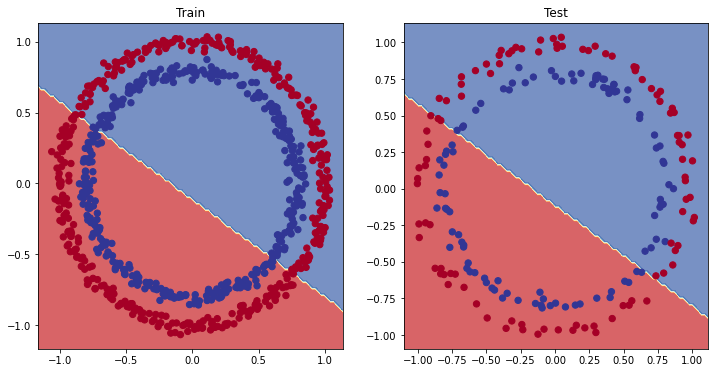

In [31]:
# Plot decisin boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model ( from a model perspective)

* Add more layers - give the model more chances to learn about pattern in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

Bu seçeneklerin tümü bir modelin bakış açısındandır, çünkü verilerden ziyade doğrudan modelle ilgilenirler.

Ve bu seçeneklerin tümü bizim (makine öğrenimi mühendisleri ve veri bilimcileri olarak) değiştirebileceğimiz değerler olduğu için **hyperparameter** olarak adlandırılırlar.

Let's try and improve our model by;
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000 

In [32]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # bu şekilde yazma işlemi, perde arkasında mümkün olduğunda hız artışlarından yararlanır

model_1 = CircleModelV1().to(device)   
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                             lr=0.1)

In [34]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probilities -> prediction labels

  # 2. Claculate the loss/acc
  loss = loss_fn(y_logits, 
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)) 

    # 2. Calculate the loss/acc
    test_loss = loss_fn(test_logits,
                       y_test)
    test_acc = accuracy_fn(y_true=y_test,
                          y_pred=test_pred)

  # Print out what's happenin'  
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


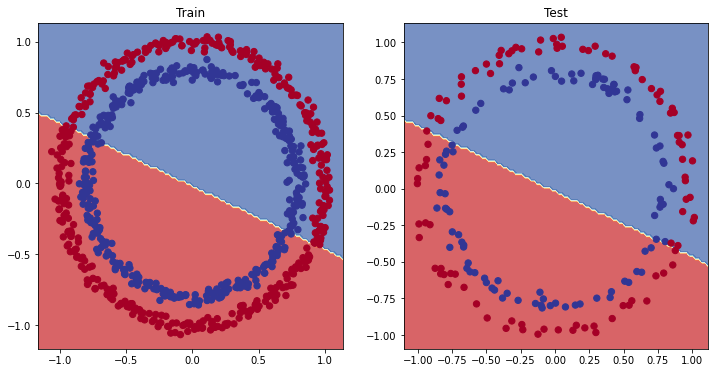

In [35]:
# Plot decisin boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Modelimizin düz bir çizgiye sığıp sığamayacağını görmek için verileri hazırlamak

Daha büyük bir sorunu gidermenin bir yolu, daha küçük bir sorunu test etmektir.


In [36]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

#Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [37]:
# Create train and test splits
train_splits = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_splits], y_regression[:train_splits]
X_test_regression, y_test_regression = X_regression[train_splits:], y_regression[train_splits:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

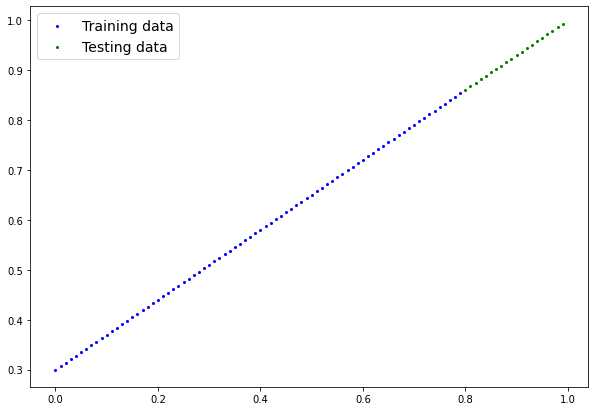

In [38]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [39]:
# Same architecture as model_1 (but using nn_Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [40]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [41]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs 
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

  ### Training
model_2.train()
for epoch in range(epochs):

  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happein'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")







Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


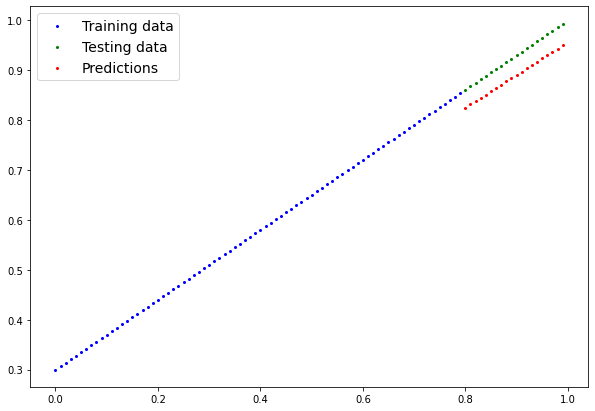

In [42]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-Linearity

"Size sonsuz miktarda düz ve düz olmayan çizgiler verilseydi hangi kalıpları çizebilirdiniz?"

Veya makine öğrenimi açısından, doğrusal ve doğrusal olmayan fonksiyonların sonsuz (ama gerçekten sonludur)?


### 6.1 Recreating non-linear data (red and blue circles)

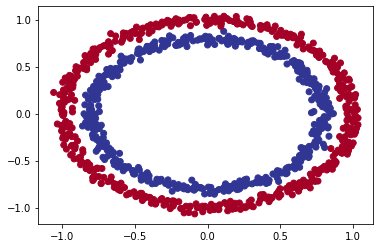

In [43]:
# Make and plot data 
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [44]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train[:5], y_train[:5], X_test[:5], y_test[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438]]),
 tensor([1., 0., 1., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = düz doğrusal
* Non-Linear = düz olmayan çizgiler

Yapay sinir ağları, potansiyel olarak verilerdeki kalıpları bulabilen doğrusal (linear) ve düz olmayan (non-linear) fonksiyonların geniş bir kombinasyonudur.

In [45]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # Doğrusal olmayan activation function'ları nereye koymalıyız?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [46]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity

In [47]:
# Randomm seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predictions probabilities -> predictions labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  # Print out what's this happenin'  
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test loss: 0.62145, Test acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions


In [48]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]  

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

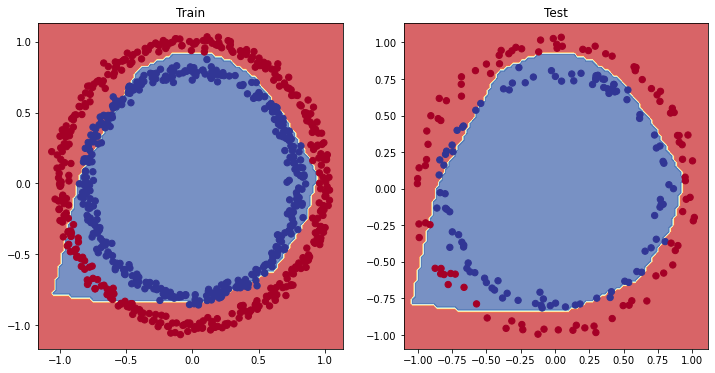

In [49]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)


**Challange**: Can you improve model_3 to do better than 80% accuracy on the test data?

## 7. Non-linear activation functions çoğaltılması

Sinir ağı, modele ne öğreneceğini söylemek yerine, ona verilerdeki kalıpları keşfetmesi için araçlar veriyoruz ve kalıpları kendi başına çözmeye çalışıyor.

And these tools are linear & non-linear fnctions.

In [50]:
# Create a tensor 
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [51]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

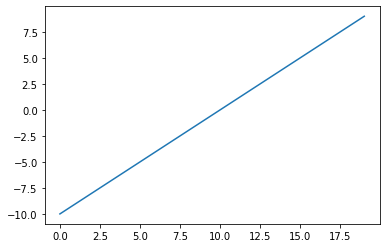

In [52]:
# Visualize the tensor
plt.plot(A)

In [53]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [54]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

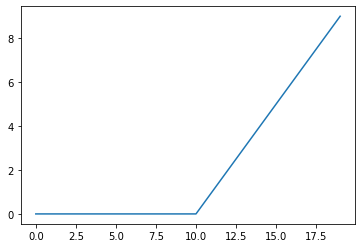

In [55]:
# Plot ReLU activation function
plt.plot(relu(A))

In [56]:
# Now let's do the same for Sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

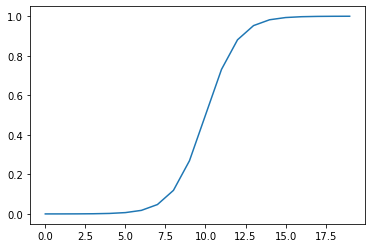

In [57]:
plt.plot(torch.sigmoid(A));

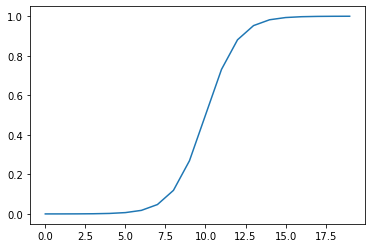

In [58]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

### 8.1 Creating a toy multi-class dataset


(750, 250, 750, 250)


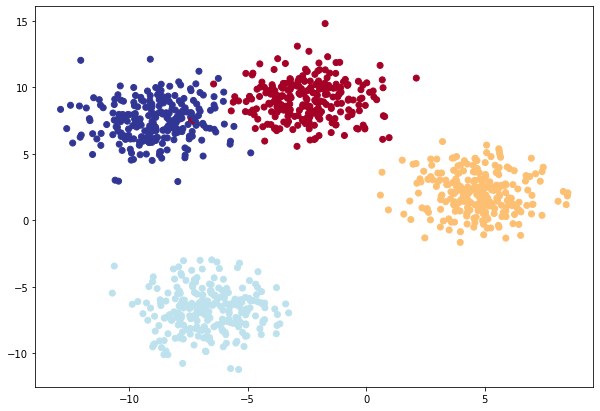

In [67]:
# Import dependencies - 
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a litle shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensor
X_blob, y_blob = torch.from_numpy(X_blob).type(torch.float32), torch.from_numpy(y_blob).type(torch.float32)
X_blob , y_blob

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, 
                                                    test_size=0.25,
                                                    random_state=RANDOM_SEED)
print(f"{len(X_blob_train), len(X_blob_test), len(y_blob_train), len(y_blob_test)}")

# Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)


### 8.2 Building a multi-class classification model in PyTorch

In [68]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [75]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    """ Initializes multi-class classification model.

    Args:
      input_features (int) : Modele giriş özelliklerinin sayısı
      output_features (int) : Çıkış özelliklerinin sayısı (çıkış sınıflarının sayısı)
      hidden_units(int) : Number of hidden units between layers, default 8 

    Returns:

    Example:
      """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4      

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)